In [5]:
pip install scipy

     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.6 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.6 kB 217.9 kB/s eta 0:00:01
     -------------------------------- ----- 51.2/60.6 kB 327.7 kB/s eta 0:00:01
     -------------------------------------- 60.6/60.6 kB 322.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/45.9 MB ? eta -:--:--
   ---------------------------------------- 0.2/45.9 MB 5.0 MB/s eta 0:00:10
   ---------------------------------------- 0.4/45.9 MB 5.5 MB/s eta 0:00:09
    --------------------------------------- 0.8/45.9 MB 7.0 MB/s eta 0:00:07
    --------------------------------------- 1.1/45.9 MB 6.3 MB/s eta 0:00:08
   - -------------------------------------- 1.5/45.9 MB 6.6 MB/s eta 0:00:07
   - -------------------------------------- 1.8/45.9 MB 7.2 MB/s eta 0:00:07
   - -------------------------------------- 2.2/45.9 MB 7.0 MB/s eta 0:00:07
   -- 

In [50]:
pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ------------------------ --------------- 184.3/294.9 kB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 3.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/11.5 MB 9.6 MB/s eta 0:00:02
   - -------------------------------------- 0.6/11.5 MB 7.1 MB/s eta 0:00:02
   -- ------------------------------------- 0.8/11.5 MB 6.9 MB/s eta 0:00:02
   --- ------------------------------------ 0.9/11.5 MB 5.1 MB/s eta 0:00:03
   --- ------------------------------------ 1.1/11.5 MB 5.1 MB/s eta 0:00:03
   ---- ----------------------------------- 1.4/11.5 MB 5.3 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/11.5 MB 5.7 MB/s eta 0:00:02
   ------- -------------------------------- 2.1/11.5 MB 5.8 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.5 MB 6.0 MB/s eta 0:00:02
   ---

In [78]:
import numpy as np
from scipy.stats import norm
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

# Question 1

1. Follow the guidelines given in that experiment to implement a random walk Metropo-
lis sampler that targets the posterior distribution of a GARCH model. For the
data, you can use simulated data at first, and then look at the same type of real
data (log-returns computed from exchange rates) in a second time

In [3]:
def simulate_garch(T, omega_1, omega_2, omega_3):
    np.random.seed(42)  # For reproducibility
    r = np.zeros(T)
    h = np.zeros(T)
    h[0] = omega_1 / (1 - omega_2 - omega_3)
    r[0] = np.random.normal(0, np.sqrt(h[0]))

    
    for t in range(1, T):
        h[t] = omega_1 + omega_2 * r[t-1]**2 + omega_3 * h[t-1]
        r[t] = np.random.normal(0, np.sqrt(h[t]))
        
    return r, h


In [7]:
# Parameters (example values)
omega_1 = 0.1
omega_2 = 0.1
omega_3 = 0.8

# Simulate data
T = 1000  # Number of time points
r, h = simulate_garch(T, omega_1, omega_2, omega_3)

In [39]:
def log_likelihood(r, omega_1, omega_2, omega_3):
    T = len(r)
    h = np.zeros(T)
    h[0] = omega_1 / (1 - omega_2 - omega_3) if (omega_2 + omega_3) < 1 else 100000  # large number for stability
    
    log_lik = 0
    for t in range(1, T):
        h[t] = omega_1 + omega_2 * r[t-1]**2 + omega_3 * h[t-1]
        log_lik -= 0.5 * (np.log(h[t]) + r[t]**2 / h[t])
    
    return log_lik

def log_posterior(r, omega_1, omega_2, omega_3, sigma_1, sigma_2, sigma_3):
    log_prior = -0.5 * (omega_1**2 / sigma_1**2 + omega_2**2 / sigma_2**2 + omega_3**2 / sigma_3**2)
    return log_likelihood(r, omega_1, omega_2, omega_3) + log_prior

def proposal(omega_old, sigma_proposal ): # function used in the MH algorithm that will "propose" the new parameter (new omega here)
    # omega_old is the list containing the old omegas, we will use a normal probability distribution to determine the new ones
    omega = np.array([0.0,0.0,0.0])
    omega[0] = np.random.normal(loc= omega_old[0], scale = sigma_proposal)
    omega[1] = np.random.normal(loc= omega_old[1], scale = sigma_proposal)
    omega[2] = np.random.normal(loc= omega_old[2], scale = sigma_proposal)

    return omega

def metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega):
    # Let's initialize our variable
    acceptation = np.array([False]*iterations) # we will trough the iterations accept or not the change of value of omega
    omega = initial_omega
    omega_sampling = [omega]
    # Let's apply the algorithm trough all the iterations
    for t in range(iterations):
        # We propose a candidate for omegas
        omega_new = proposal(omega, sigma_proposal)
        # We calculate the acceptance alpha which is ratio of the prior of the new omega over the old omega
        alpha = log_posterior(returns,omega_new[0],omega_new[1],omega_new[2],sigma_omega[0],sigma_omega[1],sigma_omega[2]) - log_posterior(returns,omega[0],omega[1],omega[2],sigma_omega[0],sigma_omega[1],sigma_omega[2])
        # We compare alpha with 1 and an uniform random number
        u = np.random.uniform(0,1)
        if alpha > 0:  # reminder that alpha is a log here so we don't compare with 1 but with 0
            acceptation[t] = True
            omega = omega_new
        if alpha < 0:
            if alpha > np.log(u): # we compare to log u and not u
                acceptation[t]= True
                omega = omega_new # we take the new omega
        omega_sampling.append(omega)
    acceptance_rate = np.sum(acceptation)/len(acceptation)*100
    return acceptance_rate, omega_sampling

**Example on simulated data**

So we are going to test few things.
First, if we get metropolis_omega near of our initial_omega that gave the return.
 Secondly, we will check if the f_tilde function allows to reduce the variance of the estimators while keeping the same expected value
 Finally, we will check the unbiasedness of our estimators that has been proven in one of the article
 

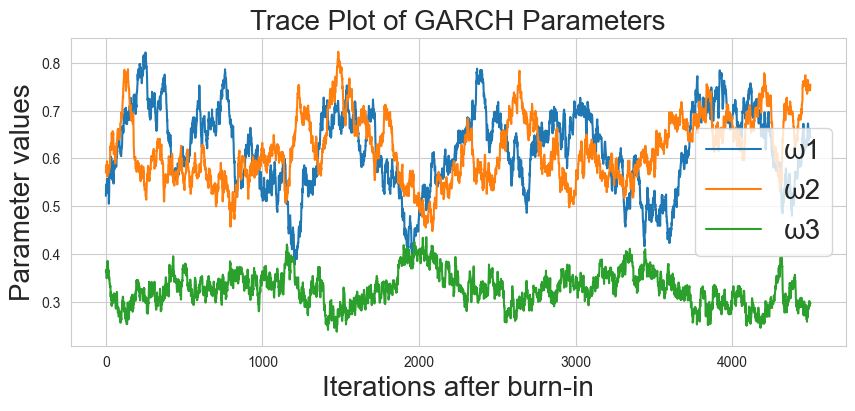

In [61]:
# Parameters
initial_omega = [0.3, 0.3, 0.3]
true_omega = [0.6, 0.7, 0.3]  # These are the true parameters we want to estimate
sigma_omega = [9, 9, 9]  # Standard deviations for the priors

# Simulate data
returns, _ = simulate_garch(900, *true_omega)

# Metropolis-Hastings settings
iterations = 5000
burn_in = 500
sigma_proposal = 0.01

# Execute the Metropolis-Hastings algorithm
acceptance_rate, omega_samples = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)

# We extract the parameter samples
omega_samples = np.array(omega_samples)  # Convert list of samples into an array for easier slicing
w1_samples = omega_samples[:, 0]
w2_samples = omega_samples[:, 1]
w3_samples = omega_samples[:, 2]

# We plot the parameter trajectories
plt.figure(figsize=(10, 4))
plt.plot(w1_samples[burn_in:], label='ω1')
plt.plot(w2_samples[burn_in:], label='ω2')
plt.plot(w3_samples[burn_in:], label='ω3')
plt.legend(fontsize=20)
plt.xlabel('Iterations after burn-in', fontsize=20)
plt.ylabel('Parameter values', fontsize=20)
plt.title('Trace Plot of GARCH Parameters', fontsize=20)
plt.grid(True)
plt.show()

As previously discussed, we expect that 
$$\frac{1}{n}\sum_{i=1}^n f(X_i) \to \int f \, d\pi \quad \text{almost surely as } n \to \infty.$$ 
In this instance, we define the identity function as $f$: $f([\omega_1,\omega_2,\omega_3]) = [\omega_1,\omega_2,\omega_3]$. Consequently, we will verify whether the empirical means of these three sequences approach the actual values of the parameters $\omega_1$, $\omega_2$, and $\omega_3$.

In [62]:
# Computing the average values post burn-in
expected_w1 = np.average(w1_samples[burn_in:])
expected_w2 = np.average(w2_samples[burn_in:])
expected_w3 = np.average(w3_samples[burn_in:])

# Display the calculated mean values
print("Calculated Mean Values:")
print(f"Expected ω1: {expected_w1}")
print(f"Expected ω2: {expected_w2}")
print(f"Expected ω3: {expected_w3}")

Calculated Mean Values:
Expected ω1: 0.6186841834559498
Expected ω2: 0.6183477349048991
Expected ω3: 0.32726154986882483


Our w1,w2,w3 implemented in the garch_simulation were : [0.1, 0.2, 0.7], therefore we have almost the same figures which means that our algorithm works well.

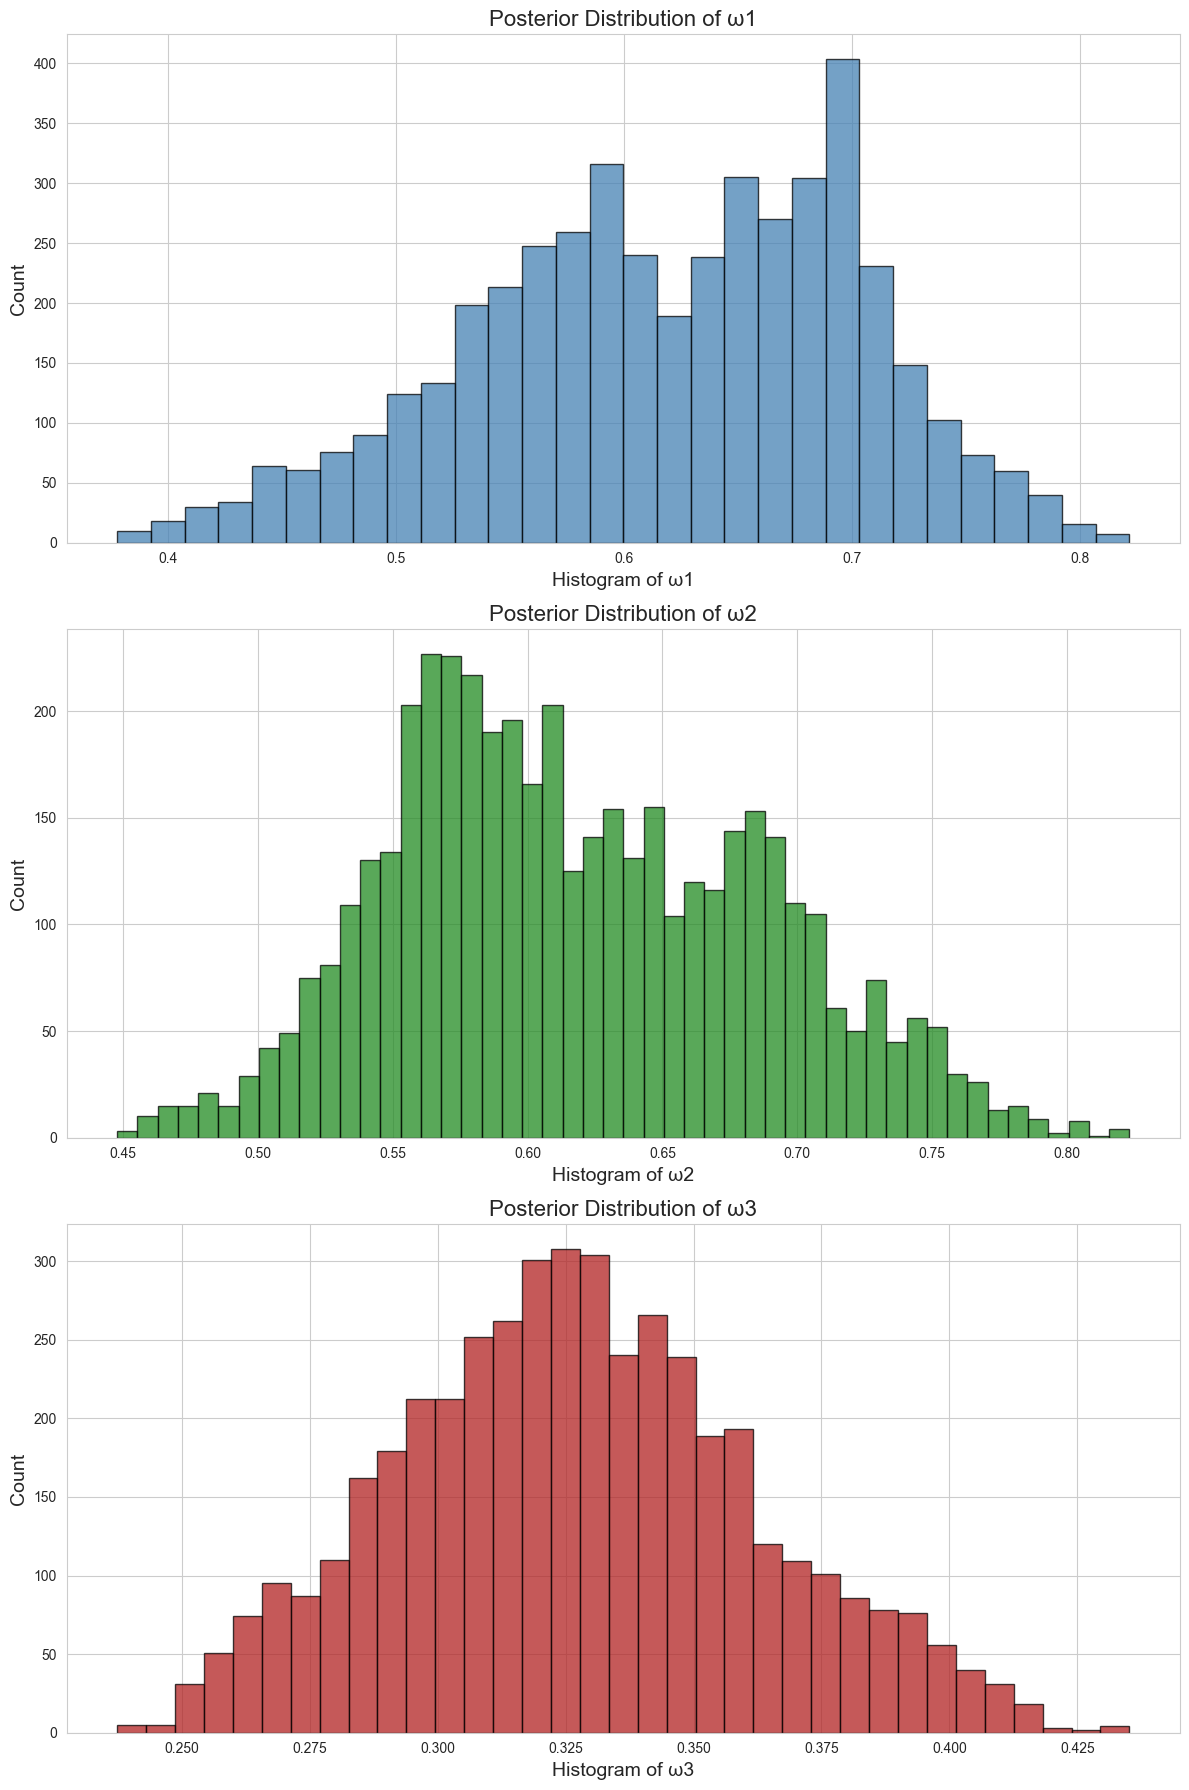

In [63]:
# Apply a seaborn style to enhance aesthetics
sns.set_style("whitegrid")

fig, axs = plt.subplots(3, figsize=(12, 18))

# Function to plot a histogram with matplotlib, with enhanced presentation
def custom_hist(data, bins, color, label, ax):
    counts, edges, _ = ax.hist(data, bins=bins, color=color, edgecolor='black', alpha=0.75)
    ax.set_xlabel(label, fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    return counts, edges

# Plot histograms with detailed customization
_, edges1 = custom_hist(w1_samples[burn_in:], 30, 'steelblue', 'Histogram of ω1', axs[0])
axs[0].set_title('Posterior Distribution of ω1', fontsize=16)

_, edges2 = custom_hist(w2_samples[burn_in:], 50, 'forestgreen', 'Histogram of ω2', axs[1])
axs[1].set_title('Posterior Distribution of ω2', fontsize=16)

_, edges3 = custom_hist(w3_samples[burn_in:], 35, 'firebrick', 'Histogram of ω3', axs[2])
axs[2].set_title('Posterior Distribution of ω3', fontsize=16)

# Fine-tuning the plot layout
plt.tight_layout()
plt.show()

We can see that these histograms of the posterior distribution of w1,w2 w3 are almost histograms from normal distribution. However, they are not perfectly centered with the empirical expected value of omega but they are indeed near of them. We could also see it with boxplot.

In [74]:
# We are now doing to develop a function that will iterate the metropolis_hasting_algorithm in order to make statistical test and study on the distributions of the omega

def mean_metropolis_algorithm(iterations1):
    expected_w1_list = []
    expected_w2_list = []
    expected_w3_list = []
    for i in range(iterations1):
        results = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)

        # Check if results structure is as expected
        if not isinstance(results, tuple) or len(results) < 2:
            raise ValueError("The results from the Metropolis-Hasting algorithm do not match the expected format.")

        omega_samples = results[1]  # Assuming the second item is the list of omega samples

        # Prepare lists to hold the current iteration values for w1, w2, w3
        w1_samples = []
        w2_samples = []
        w3_samples = []

        # Extract samples depending on whether they are scalar or array-like
        for sample in omega_samples:
            if np.isscalar(sample):  # Handling cases where the sample might be a single scalar value
                w1_samples.append(sample)  # Assuming scalar results pertain to w1 or need clarification on which omega they relate to
            else:  # Otherwise, handle as arrays
                w1_samples.append(sample[0])
                w2_samples.append(sample[1])
                w3_samples.append(sample[2])

        # Calculate means after burn-in period
        w1_expected = np.mean(w1_samples[burn_in:])
        w2_expected = np.mean(w2_samples[burn_in:])
        w3_expected = np.mean(w3_samples[burn_in:])
        
        expected_w1_list.append(w1_expected)
        expected_w2_list.append(w2_expected)
        expected_w3_list.append(w3_expected)
        
    return [expected_w1_list, expected_w2_list, expected_w3_list]

Example on real date (exchange rate like on the first article on zero variance)

In [75]:
# Parameters
initial_omega = [0.3, 0.3, 0.3]
true_omega = [0.6, 0.7, 0.3]  # These are the true parameters we want to estimate
sigma_omega = [9, 9, 9]  # Standard deviations for the priors

# Simulate data
returns, _ = simulate_garch(900, *true_omega)

# Metropolis-Hastings settings
iterations = 3000 # less iterations than before
burn_in = 300 # smaller burn_in too
sigma_proposal = 0.01


In [76]:
mean_met_alg = mean_metropolis_algorithm(20)

In [77]:
print(mean_met_alg)

[[0.6116491386247296, 0.5993130729631241, 0.5462929629809434, 0.5744445146086531, 0.5664165056156716, 0.5709260485612353, 0.5638615396755638, 0.5737691300812786, 0.5929858716559766, 0.5690610360414491, 0.5775764792675119, 0.5393788979205439, 0.5527927323480126, 0.5117616517306783, 0.57942827370125, 0.5573774999041728, 0.5553889395205466, 0.5268783079961229, 0.5608252972857134, 0.574332482142271], [0.6060660774961191, 0.6246585077409983, 0.6129158483686351, 0.6062577103272443, 0.6301152858867707, 0.5954178853415766, 0.6248695687766227, 0.6176730006833375, 0.6161460694104786, 0.6037618380425405, 0.615300240902802, 0.5970055349319496, 0.6039619847899436, 0.6325420586308903, 0.6098179601212466, 0.6142973731256641, 0.6462198261155061, 0.6162732096152618, 0.6243761586715592, 0.640892954308967], [0.33091923651448774, 0.33104298451925135, 0.34081689529909837, 0.33783843571333527, 0.33280379120579684, 0.3465618010006526, 0.33311772852893584, 0.3362164951173019, 0.3274235048360092, 0.34190379348

In [82]:
# So now, as we said before we are going to check if the f_tilde function allows to reduce the variance of the estimators while keeping the same expected value
# Thanks to the mean_metropolis_algorithm we can get the variance of our estimators

def variance_estimators(mean_met_alg):
    return statistics.variance(mean_met_alg[0]), statistics.variance(mean_met_alg[1]), statistics.variance(mean_met_alg[2])

# So the variance without the method used in the article is 

print("The variance without the method used in the article is:")
print(f"Variance de ω1,w2,w3 : {variance_estimators(mean_met_alg)}")

# We will see the variance reduction in the next questions

# Now, let's check the unbiasedness of our estimators that has been proven in one of the article.

def bias_estimators(mean_met_alg):
    return statistics.mean(mean_met_alg[0]) - true_omega[0], statistics.mean(mean_met_alg[1]) - true_omega[1], statistics.mean(mean_met_alg[2]) - true_omega[2]

bias_estimators(mean_met_alg)

# There is still some bias but it is very small and it may be explicated by the few numbers of iterations of the metropolis_hasting_algorithm, so like it was said in the paper, there is the unbiasedness of the estimators

# To end this part we can finally check the mean squared error of the estimators

mse = {}

# We calculate the MSE for each parameter
for i in range(1,4):
    mse[i] = statistics.mean([(omega - true_omega[i-1])**2 for omega in mean_met_alg[i-1]])

print(mse)

# The mse for both parameters are very small.

The variance without the method used in the article is:
Variance de ω1,w2,w3 : (0.0005484784422592886, 0.00018626548703518358, 4.680754370516939e-05)
{1: 0.0017304929184901656, 2: 0.0070778338571271205, 3: 0.00143157029537744}


**Let's do the example on real data as it is asked in the end of the first question**